In [2]:
import math
math.tanh(-2.2) # 垃圾车

-0.9757431300314515

In [3]:
math.tanh(0.1) # 熊

0.09966799462495582

In [4]:
math.tanh(2.5) # 狗

0.9866142981514303

In [5]:
%matplotlib inline
import numpy as np 
import torch 
import torch.optim as optim 

torch.set_printoptions(edgeitems=2, linewidth=75)

In [6]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [7]:
# 划分验证集
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

# Returns a random permutation of integers from 0 to n - 1.
shuffled_indices = torch.randperm(n_samples)


train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices, n_val

(tensor([10,  8,  7,  6,  0,  2,  3,  1,  4]), tensor([9, 5]), 2)

In [8]:
# 训练集
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

# 验证集
t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

# 正则化
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [9]:
import torch.nn as nn

linear_model = nn.Linear(1, 1)
linear_model(t_un_val)
# model.forward(x) 不能这样调用

tensor([[-1.5001],
        [-1.2975]], grad_fn=<AddmmBackward>)

In [10]:
linear_model.weight

Parameter containing:
tensor([[-0.1762]], requires_grad=True)

In [11]:
linear_model.bias

Parameter containing:
tensor([-0.4357], requires_grad=True)

In [12]:
x = torch.ones(1)
linear_model(x)

tensor([-0.6119], grad_fn=<AddBackward0>)

In [13]:
x = torch.ones(10, 1)
linear_model(x), x

(tensor([[-0.6119],
         [-0.6119],
         [-0.6119],
         [-0.6119],
         [-0.6119],
         [-0.6119],
         [-0.6119],
         [-0.6119],
         [-0.6119],
         [-0.6119]], grad_fn=<AddmmBackward>),
 tensor([[1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.],
         [1.]]))

In [14]:
# 构建模型
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr = 1e-2
)

In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(
    linear_model.parameters(),
    lr=1e-2
)

In [16]:
linear_model.parameters()

<generator object Module.parameters at 0x7f2aabdee3d0>

In [17]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.9088]], requires_grad=True),
 Parameter containing:
 tensor([0.1107], requires_grad=True)]

In [18]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [19]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # 调用MSEloss
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 385.1604, Validation loss 279.0768
Epoch 1000, Training loss 3.3732, Validation loss 4.0836
Epoch 2000, Training loss 2.8629, Validation loss 3.9756
Epoch 3000, Training loss 2.8541, Validation loss 3.9680

Parameter containing:
tensor([[5.4243]], requires_grad=True)
Parameter containing:
tensor([-17.2504], requires_grad=True)


In [20]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [23]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [25]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [27]:
from collections import OrderedDict

# 使用orderdict给每一层命名
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model


Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [28]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [29]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0507], requires_grad=True)

In [30]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model=seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train=t_un_train,
    t_u_val=t_un_val,
    t_c_train=t_c_train,
    t_c_val=t_c_val
)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 221.1562, Validation loss 134.6617
Epoch 1000, Training loss 4.4037, Validation loss 4.3943
Epoch 2000, Training loss 2.8884, Validation loss 9.4190
Epoch 3000, Training loss 1.8677, Validation loss 6.0782
Epoch 4000, Training loss 1.6281, Validation loss 4.8250
Epoch 5000, Training loss 1.5481, Validation loss 3.9522
output tensor([[15.7737],
        [ 7.5577]], grad_fn=<AddmmBackward>)
answer tensor([[13.],
        [ 8.]])
hidden tensor([[-0.0172],
        [-0.0156],
        [-0.0362],
        [ 0.0012],
        [ 0.0036],
        [ 0.0037],
        [-0.0377],
        [ 0.0416]])


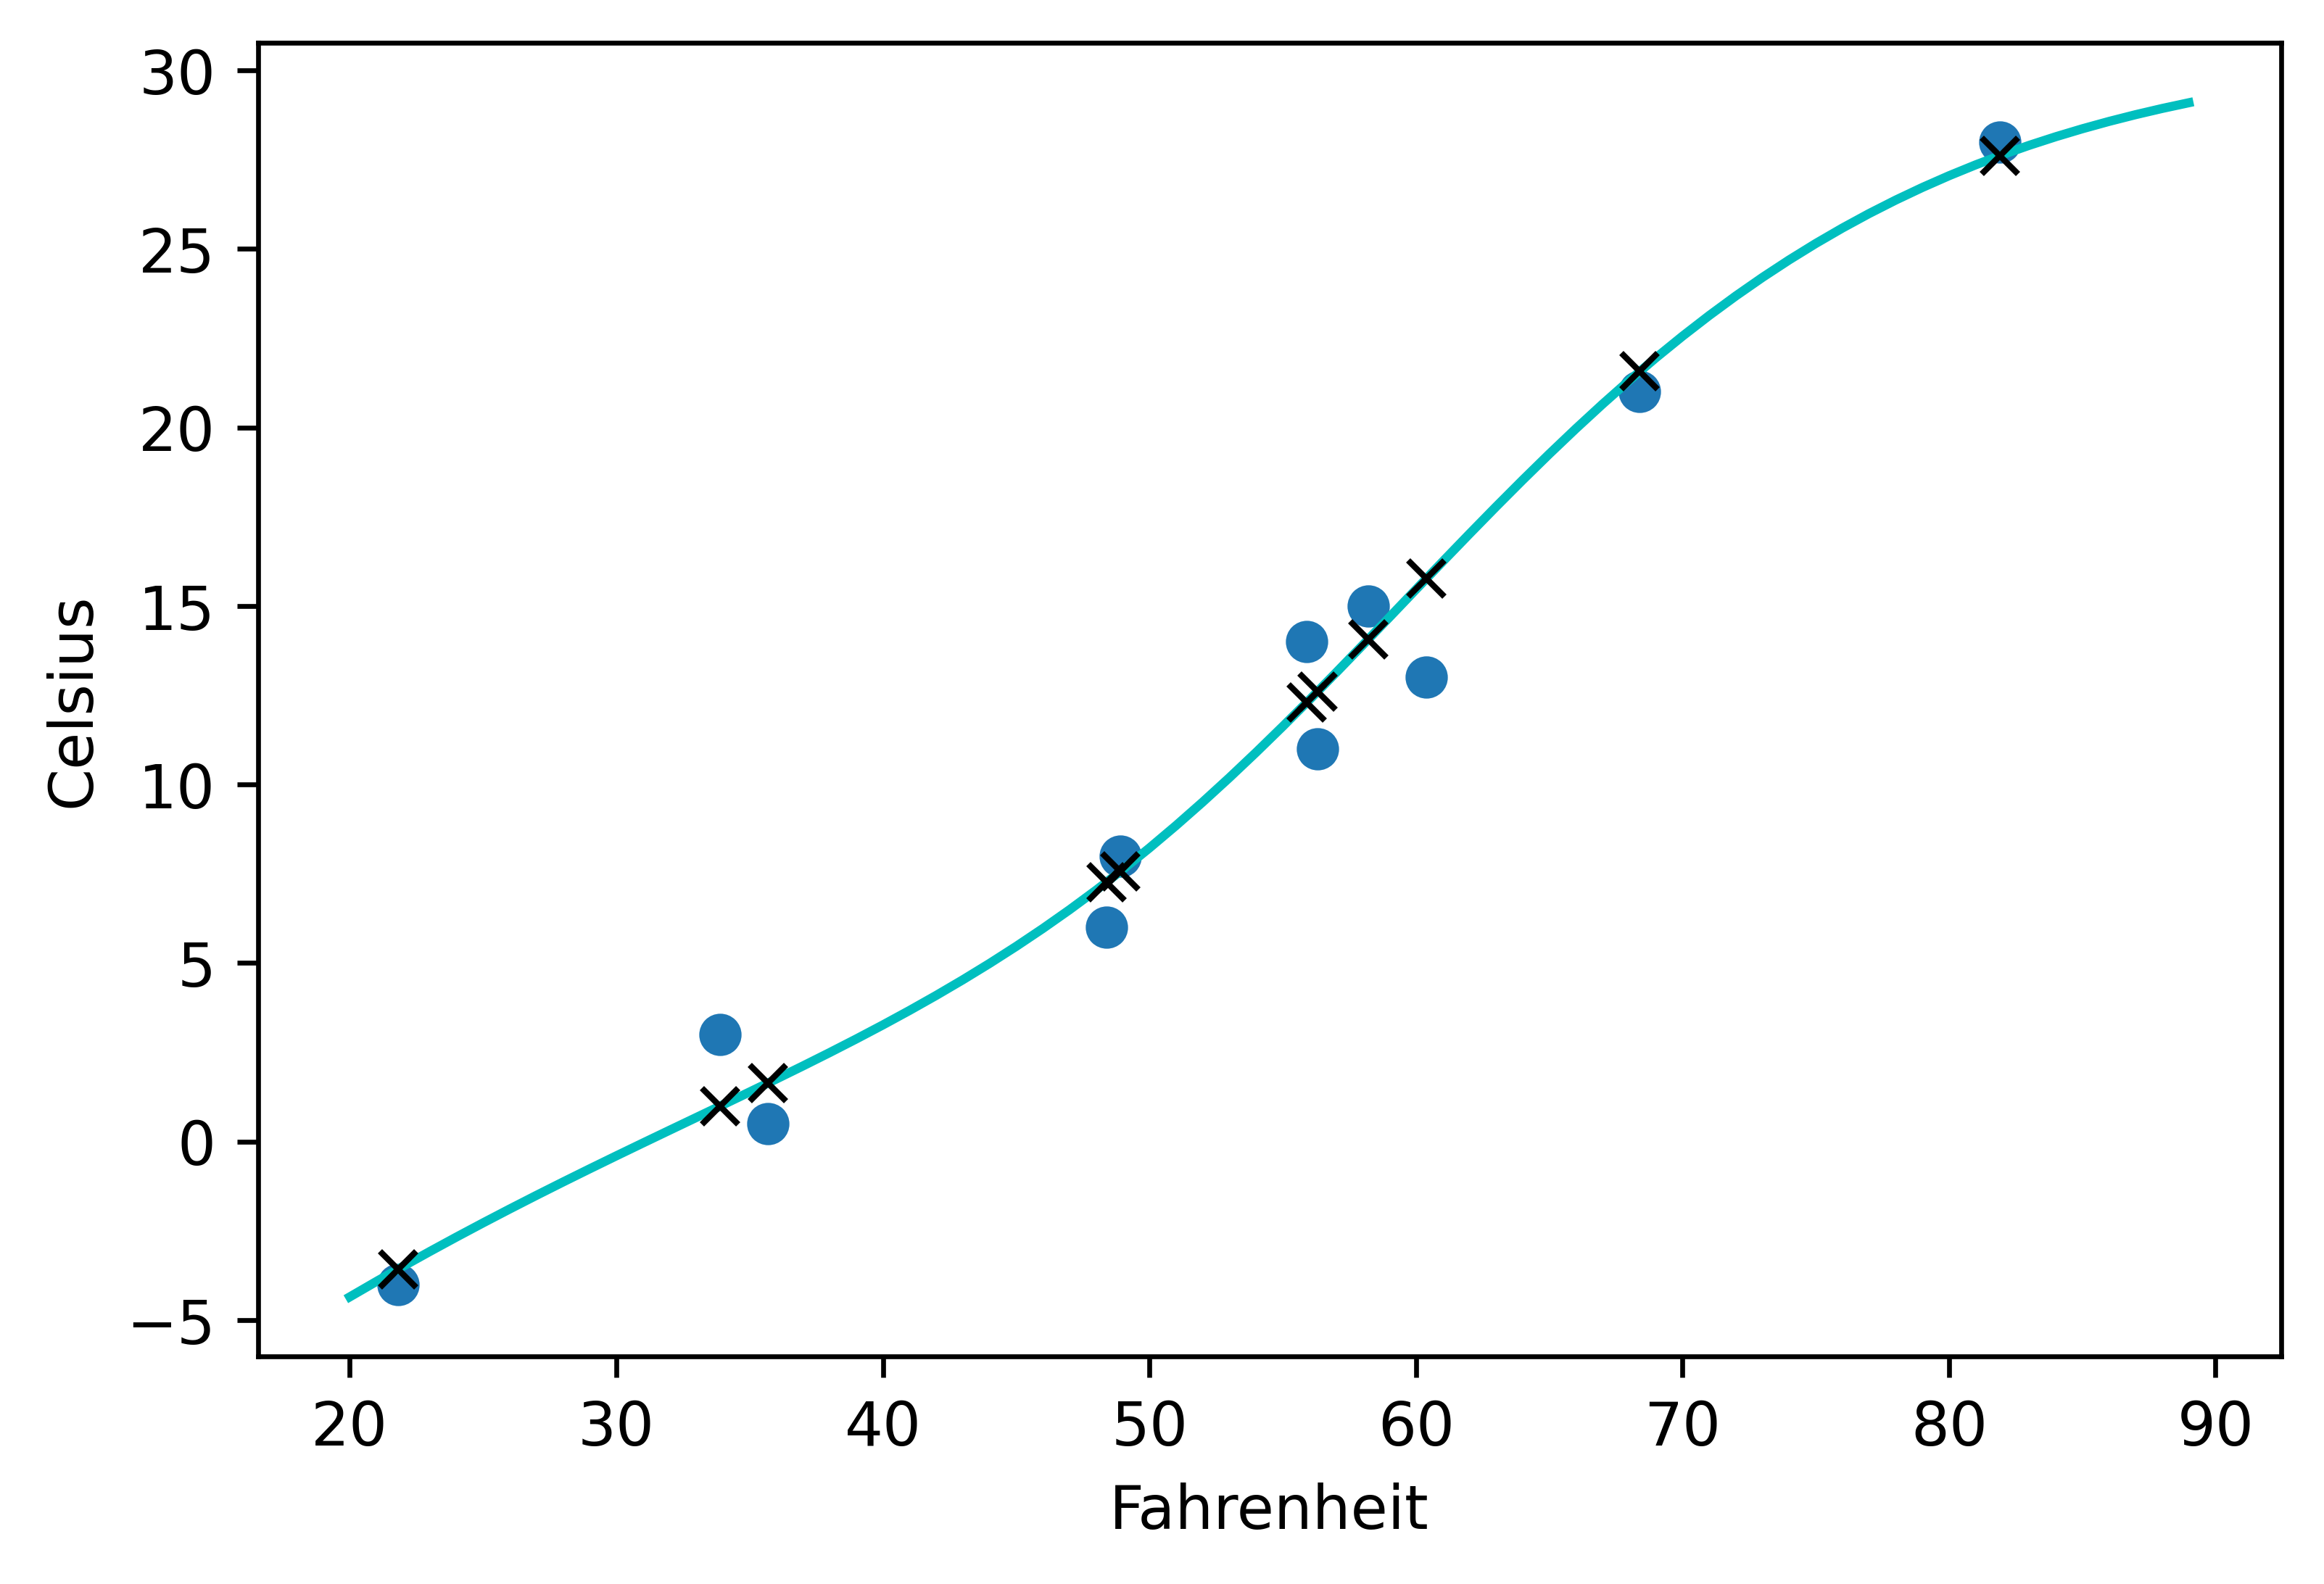

In [33]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

Epoch 1, Training loss 210.0912, Validation loss 123.6501
Epoch 1000, Training loss 65.5476, Validation loss 4.1384
Epoch 2000, Training loss 45.6248, Validation loss 3.5466
Epoch 3000, Training loss 26.8795, Validation loss 3.2781
Epoch 4000, Training loss 14.2374, Validation loss 3.6779
Epoch 5000, Training loss 8.3430, Validation loss 4.2491


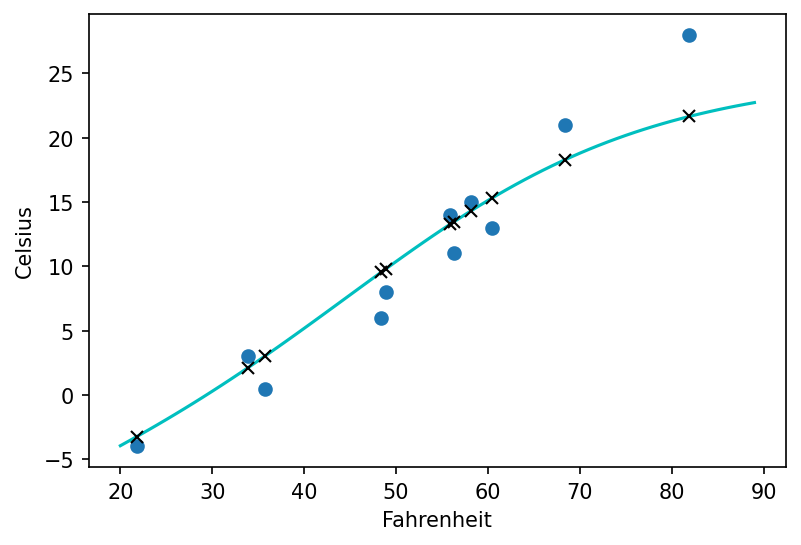

In [37]:
# exercises

# 增加神经元中的数量
neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

# 减小学习率
optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs=5000,
    optimizer=optimizer,
    model= seq_model,
    loss_fn=nn.MSELoss(),
    t_u_train= t_un_train,
    t_u_val= t_un_val,
    t_c_train= t_c_train,
    t_c_val= t_c_val
)

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")

plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')

